In [131]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import metrics

# Preparing dataset

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
raw_df = load_dataset('../../databases/Tcritical.csv')
raw_df = raw_df.drop(['file', 'macro'], axis=1)
#raw_df.head()

In [4]:
df = raw_df.copy()

'''
Variables
C, C**2, C*Mn, C*Si, C*Cr, C*Ni, 
Mn, Mn**2, Mn*Si, Mn*Cr, Mn*Ni, 
Si, Si*Si, Si*Cr, Si*Ni, 
Cr, Cr**2, Cr*Ni,
Ni, Ni**2]
'''

df['C2'] = df['C'].apply(lambda x: x**2)
df['CMn'] = df['C'] * df['Mn']
df['CSi'] = df['C'] * df['Si']
df['CCr'] = df['C'] * df['Cr']
df['CNi'] = df['C'] * df['Ni']
df['Mn2'] = df['Mn'].apply(lambda x: x**2)
df['MnSi'] = df['Si'] * df['Mn']
df['MnCr'] = df['Cr'] * df['Mn']
df['MnNi'] = df['Ni'] * df['Mn']
df['Si'] = df['Si'].apply(lambda x: x**2)
df['SiCr'] = df['Cr'] * df['Si']
df['SiNi'] = df['Si'] * df['Ni']
df['Cr2'] = df['Cr'].apply(lambda x: x**2)
df['CrNi'] = df['Cr'] * df['Ni']
df['Ni2'] = df['Ni'].apply(lambda x: x**2)

df.head()

,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid,C2,...,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
0,0.0,0.0001,1.000000e-08,0.0001,0.000100,NaN,NaN,911.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-12,1.000000e-12,1.000000e-08,1.000000e-08,1.000000e-08
1,0.0,0.0001,1.000000e-08,0.0001,0.750075,NaN,NaN,880.26,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,7.500750e-05,1.000000e-12,7.500750e-09,1.000000e-08,7.500750e-05,5.626125e-01
2,0.0,0.0001,1.000000e-08,0.0001,1.500050,NaN,NaN,853.25,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.500050e-04,1.000000e-12,1.500050e-08,1.000000e-08,1.500050e-04,2.250150e+00
3,0.0,0.0001,1.000000e-08,0.0001,2.250025,NaN,NaN,829.60,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,2.250025e-04,1.000000e-12,2.250025e-08,1.000000e-08,2.250025e-04,5.062613e+00
4,0.0,0.0001,1.000000e-08,0.0001,3.000000,NaN,NaN,808.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,3.000000e-04,1.000000e-12,3.000000e-08,1.000000e-08,3.000000e-04,9.000000e+00


# Preparing A3 dataset

In [5]:
df1 = df.copy()
df1 = df.drop(['A1', 'A1prime'], axis=1)
is_na = df1['A3'].isna() 
df1 = df1.loc[~is_na, :] #REMOVE ALL A3 NAN
df1_ = df1.copy()
df1_ = df1_.drop(['eutectoid'], axis=1) #REMOVE EUCTETOID COLLUMN BECAUSE IT'S A STRING
#df1_

# A3 Regression

In [90]:
def _split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A3']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A3'], axis=1)
    X_test = X_test.drop(['A3'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    print('Test size: {}'.format(X_test.shape))
    return X_train, X_test, y_train, y_test

## Train Size 70%

In [124]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df1_, 0.7)

Train size: (4791, 19)
Test size: (2054, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [93]:
y_test.head()

4277     813.96
5322    1008.43
4292     899.99
1613     792.50
3144     855.06
Name: A3, dtype: float64

In [94]:
y_train.head()

5275    911.41
30      956.51
1906    777.76
2212    756.39
4192    911.98
Name: A3, dtype: float64

In [114]:
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

896.3291215014789

In [115]:
list(zip(X_test.keys(), model.coef_))

[('C', -262.6913897889049),
 ('Mn', -41.0124245674925),
 ('Si', 10.027047364738646),
 ('Cr', -9.012024126134541),
 ('Ni', -33.3369506223936),
 ('C2', 215.98962057092717),
 ('CMn', 27.06417150894294),
 ('CSi', -8.246162579934989),
 ('CCr', 25.87816956109647),
 ('CNi', 25.9294402420976),
 ('Mn2', 1.315755403166023),
 ('MnSi', 1.075877091818366),
 ('MnCr', 2.1663146271083806),
 ('MnNi', 1.974137195802674),
 ('SiCr', -0.8800394775533249),
 ('SiNi', -0.48408789787227535),
 ('Cr2', 1.1117325756543437),
 ('CrNi', 2.478813489705872),
 ('Ni2', 0.8503596269121272)]

In [125]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

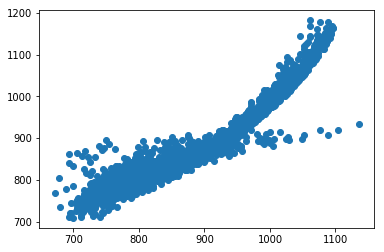

In [126]:
## The line / model
plt.scatter(y_test, predictions)
#plt.xlabel(“True Values”)
#plt.ylabel(“Predictions”)
plt.show()

In [127]:
metrics.r2_score(y_test, predictions)

0.8807748471556844

In [132]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

36.1867729133932

## Train Size 80%

In [133]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df1_, 0.8)

Train size: (5476, 19)
Test size: (1369, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [134]:
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

893.2257134168982

In [135]:
list(zip(X_test.keys(), model.coef_))

[('C', -261.1753153220493),
 ('Mn', -40.409609047923155),
 ('Si', 10.112628873981503),
 ('Cr', -7.66764694263189),
 ('Ni', -32.44386325589558),
 ('C2', 216.0753734030949),
 ('CMn', 26.989264493348532),
 ('CSi', -8.378830409182925),
 ('CCr', 25.553020179146003),
 ('CNi', 25.430291611650542),
 ('Mn2', 1.336661055251549),
 ('MnSi', 1.0962279500999488),
 ('MnCr', 1.9547738185634616),
 ('MnNi', 1.7814164625761828),
 ('SiCr', -0.915680001104493),
 ('SiNi', -0.5003619953379947),
 ('Cr2', 0.9852984624601098),
 ('CrNi', 2.2705386323444166),
 ('Ni2', 0.9299984427325296)]

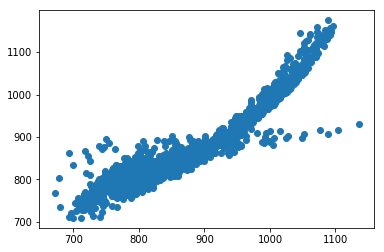

In [136]:
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
plt.scatter(y_test, predictions)
plt.show()

In [137]:
#R2
metrics.r2_score(y_test, predictions)

0.8774082232916405

In [138]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

36.91817441410102

# A3 regression with database normalization

In [60]:
df2_ = df1_.copy()
df2_ = df2_.loc[~is_na, :]

In [ ]:
'''
AINDA NÃO SEI SE PRECISA DISSO
def standardize(feature):
    return np.divide(np.subtract(feature - np.mean(feature)), np.std(feature))
'''

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_.iloc[:, :-1])
df2_.iloc[:, :-1] = scaler.transform(df2_.iloc[:, :-1])

In [62]:
df2_.head()

,C,Mn,Si,Cr,Ni,A3,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
0,-1.59196,-1.420018,-1.014318,-1.415661,-1.418927,0.315327,-1.070703,-0.956883,-0.957037,-0.957237,-0.95691,-1.020358,-0.896146,-0.896975,-0.897060,-0.714945,-0.716194,-1.018043,-0.896749,1.000000e-08
1,-1.59196,-1.420018,-1.014318,-1.415661,-0.711376,0.013911,-1.070703,-0.956883,-0.957037,-0.957237,-0.95691,-1.020358,-0.896146,-0.896975,-0.897030,-0.714945,-0.716194,-1.018043,-0.896719,5.626125e-01
2,-1.59196,-1.420018,-1.014318,-1.415661,-0.003825,-0.245447,-1.070703,-0.956883,-0.957037,-0.957237,-0.95691,-1.020358,-0.896146,-0.896975,-0.897000,-0.714945,-0.716194,-1.018043,-0.896689,2.250150e+00
3,-1.59196,-1.420018,-1.014318,-1.415661,0.703727,-0.472541,-1.070703,-0.956883,-0.957037,-0.957237,-0.95691,-1.020358,-0.896146,-0.896975,-0.896970,-0.714945,-0.716194,-1.018043,-0.896659,5.062613e+00
4,-1.59196,-1.420018,-1.014318,-1.415661,1.411278,-0.673709,-1.070703,-0.956883,-0.957037,-0.957237,-0.95691,-1.020358,-0.896146,-0.896975,-0.896941,-0.714945,-0.716194,-1.018043,-0.896630,9.000000e+00


## Normalization & Train Size 70%

In [146]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_, 0.7)

Train size: (4791, 19)
Test size: (2054, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [147]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

-0.026212899769096284

In [148]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -1.1931922056638908),
 ('Mn', -0.41719640605024044),
 ('Si', 0.31869714094450846),
 ('Cr', -0.09176890630181309),
 ('Ni', -0.3393047023257462),
 ('C2', 1.5318828156714714),
 ('CMn', 0.3067432051755709),
 ('CSi', -0.09345994838253979),
 ('CCr', 0.2932782579990827),
 ('CNi', 0.2938870785689815),
 ('Mn2', 0.04192107966165463),
 ('MnSi', 0.02599876271695831),
 ('MnCr', 0.05236774466398319),
 ('MnNi', 0.04770369599695075),
 ('SiCr', -0.05960283385954036),
 ('SiNi', -0.032890058868410364),
 ('Cr2', 0.03542892830707417),
 ('CrNi', 0.05992180820983349),
 ('Ni2', 0.008165407218013489)]

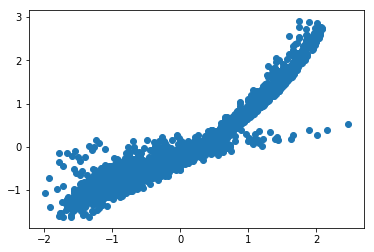

In [149]:
plt.scatter(y2_test, predictions2)
plt.show()

In [150]:
#R2
metrics.r2_score(y2_test, predictions2)

0.8807748471556847

In [151]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.3474762058220069

## Normalization && Train Size 80%

In [152]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_, 0.8)

Train size: (5476, 19)
Test size: (1369, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [153]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

-0.03062250475232043

In [154]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -1.1863059189130412),
 ('Mn', -0.4110643016714367),
 ('Si', 0.32141724201926003),
 ('Cr', -0.07807919330722286),
 ('Ni', -0.3302148264557887),
 ('C2', 1.532491008276497),
 ('CMn', 0.3058942149138121),
 ('CSi', -0.09496357244443998),
 ('CCr', 0.28959332796170817),
 ('CNi', 0.2882296740355965),
 ('Mn2', 0.04258715141355074),
 ('MnSi', 0.026490544854132034),
 ('MnCr', 0.04725402992039709),
 ('MnNi', 0.04304672925234435),
 ('SiCr', -0.06201667580421341),
 ('SiNi', -0.033995758940713224),
 ('Cr2', 0.03139969930900618),
 ('CrNi', 0.054887058274203676),
 ('Ni2', 0.008930122922938693)]

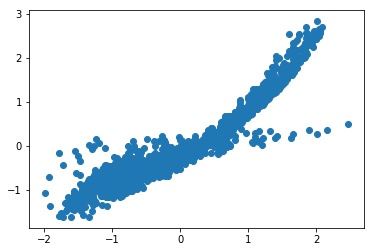

In [155]:
plt.scatter(y2_test, predictions2)
plt.show()

In [156]:
#R2
metrics.r2_score(y2_test, predictions2)

0.8774082232916397

In [157]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.3544993415685068

# Summarizing...

### Non-standardized

|  | 0.7 | 0.8 |
| --- | --- | --- |
| R2 | 0.88077 | 0.87741 |
| RMSE | 36.18677 | 36.91817 |

### Standardized

|  | 0.7 | 0.8 |
| --- | --- | --- |
| R2 | 0.88077 | 0.87408 |
| RMSE | 0.34748 | 0.35450 |

### Next steps
- other metrics: relative percentage error